In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.stattools import durbin_watson

In [ ]:
df = pd.read_csv(r'/content/education_career_success.csv')
#дропнем сразу id т.к. мешается в дальнейшем
df = df.drop('Student_ID', axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    5000 non-null   int64  
 1   Gender                 5000 non-null   object 
 2   High_School_GPA        5000 non-null   float64
 3   SAT_Score              5000 non-null   int64  
 4   University_Ranking     5000 non-null   int64  
 5   University_GPA         5000 non-null   float64
 6   Field_of_Study         5000 non-null   object 
 7   Internships_Completed  5000 non-null   int64  
 8   Projects_Completed     5000 non-null   int64  
 9   Certifications         5000 non-null   int64  
 10  Soft_Skills_Score      5000 non-null   int64  
 11  Networking_Score       5000 non-null   int64  
 12  Job_Offers             5000 non-null   int64  
 13  Starting_Salary        5000 non-null   float64
 14  Career_Satisfaction    5000 non-null   int64  
 15  Year

# 1. данные

In [ ]:
df[['Starting_Salary', 'Age', 'SAT_Score', 'University_GPA']].describe()
# а тут остальное
# df.describe()

,Starting_Salary,Age,SAT_Score,University_GPA
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,50563.540000,23.442200,1253.832000,3.020028
std,14494.958207,3.473712,203.228954,0.576047
min,25000.000000,18.000000,900.000000,2.000000
25%,40200.000000,20.000000,1076.000000,2.520000
50%,50300.000000,23.000000,1257.000000,3.030000
75%,60500.000000,26.000000,1432.000000,3.510000
max,101000.000000,29.000000,1600.000000,4.000000


# 2. Предварительная обработка данных

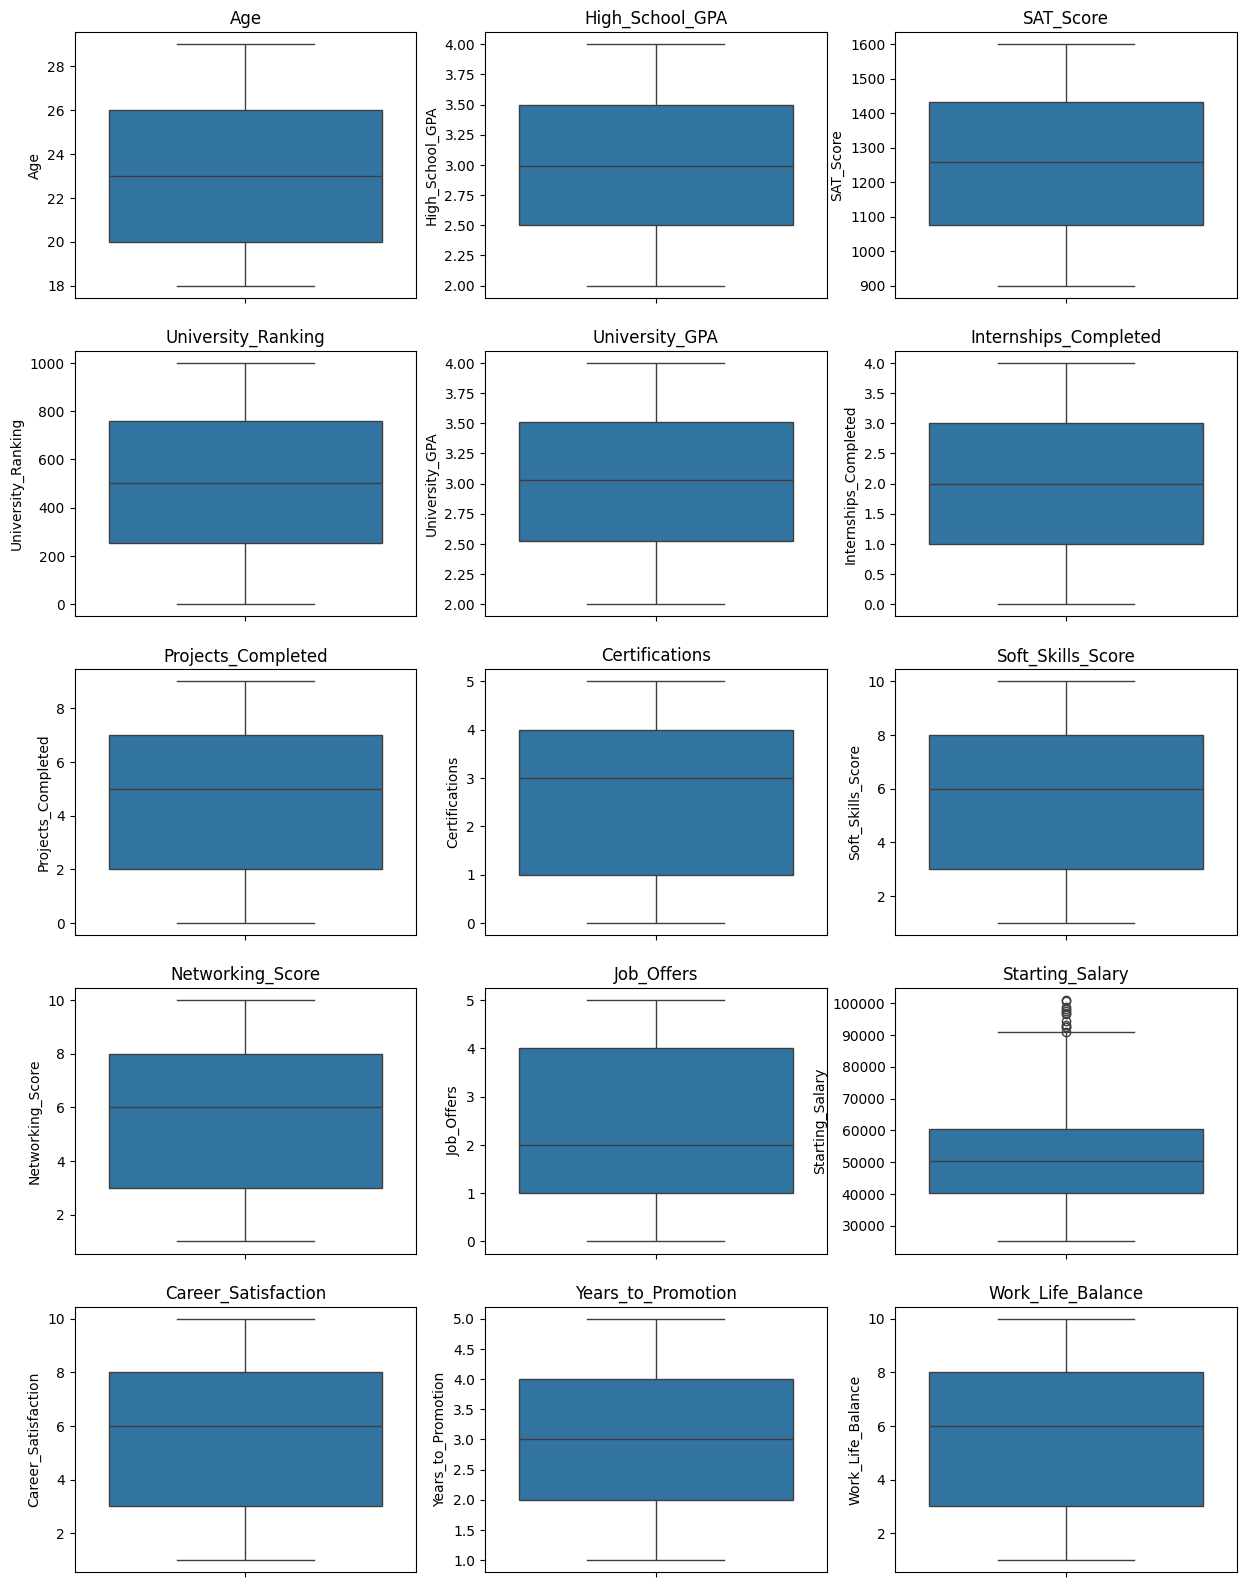

In [ ]:
# выбросы

numeric_df = df.select_dtypes(include=['float', 'int']) # тут кол. данные

n_cols = 3
n_rows = (len(numeric_df.columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 20))

for i, column in enumerate(numeric_df.columns):
    row = i // n_cols
    col = i % n_cols
    sns.boxplot(data = numeric_df[column], ax = axes[row, col])
    axes[row, col].set_title(column)



In [ ]:
# удаляем выбросы, 8 удалилось

df = df[df['Starting_Salary'] < df['Starting_Salary'].mean() + 3 * df['Starting_Salary'].std()]


<Axes: >

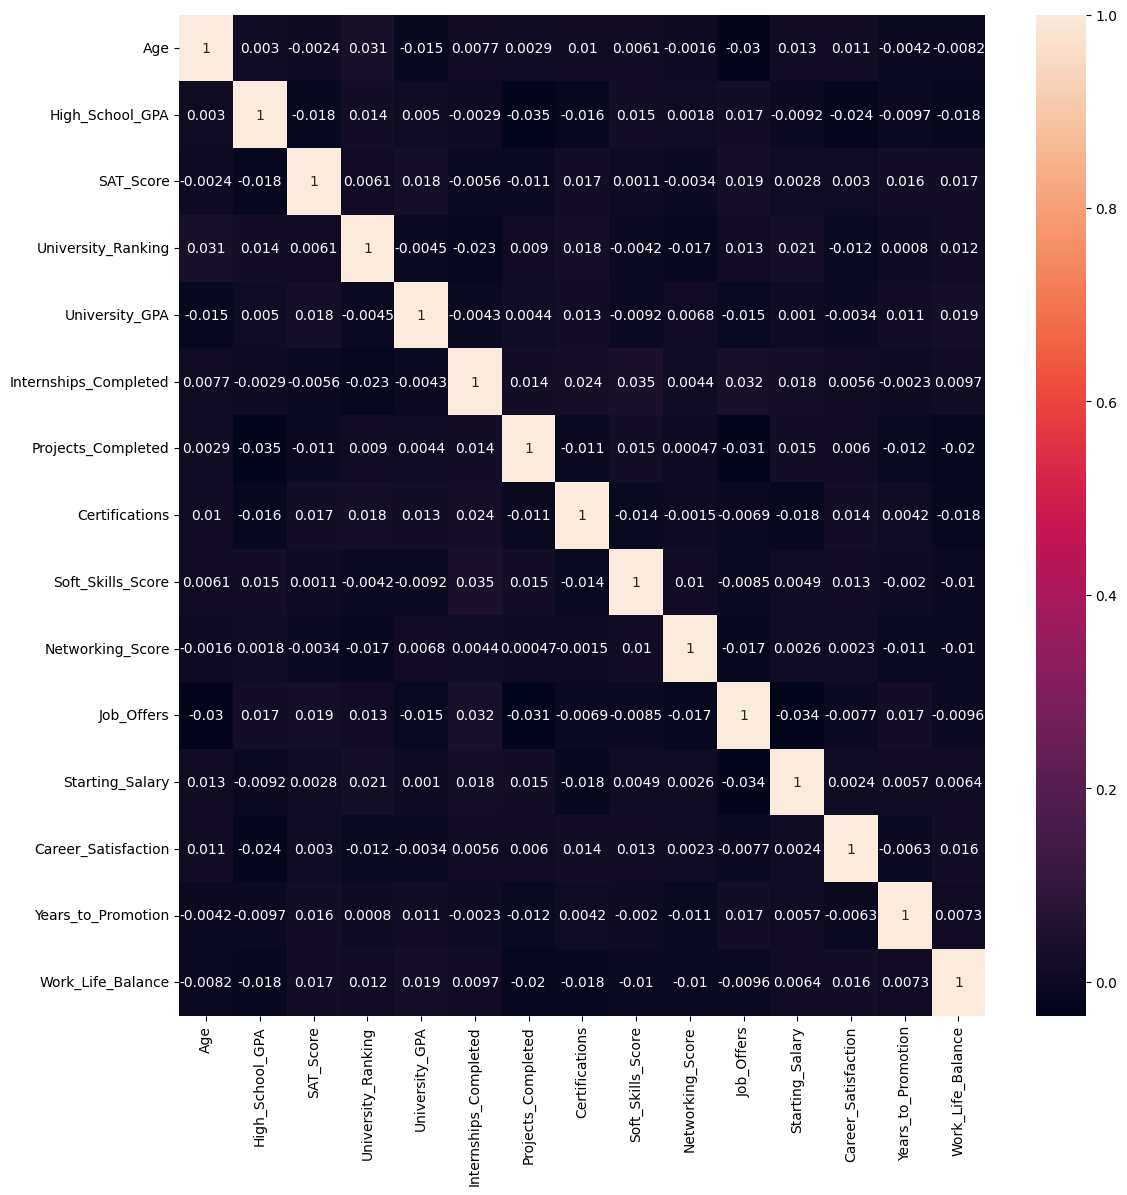

In [ ]:
#корр. матрица

fig = plt.figure(figsize = (13, 13))
sns.heatmap(numeric_df.corr(), annot = True)

# **3. EDA**

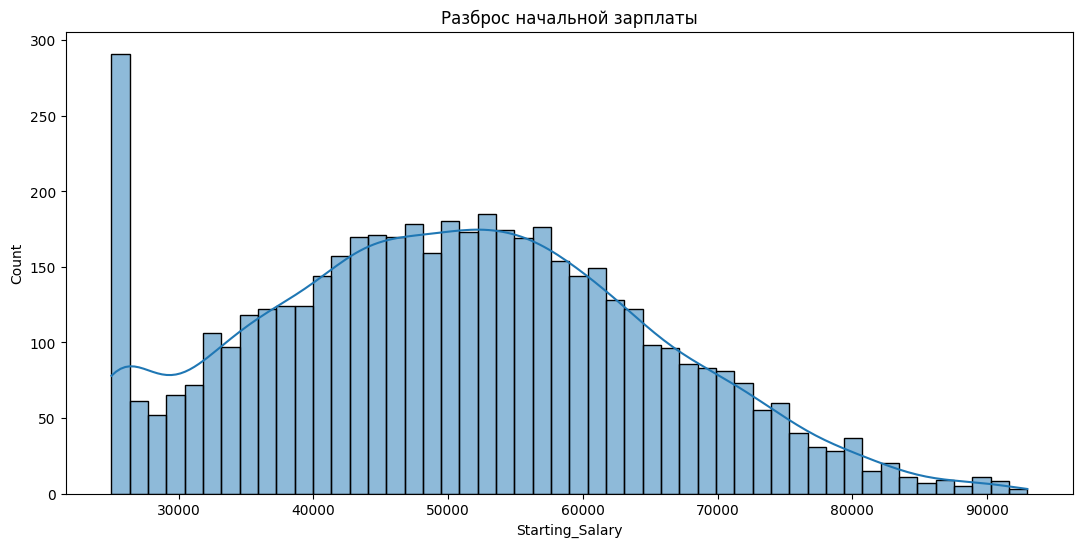

In [ ]:
# разброс начальной зп

fig, (ax1) = plt.subplots(figsize=(13,6))
ax1 = sns.histplot(df['Starting_Salary'], bins=50, kde=True)
ax1 = plt.title("Разброс начальной зарплаты")

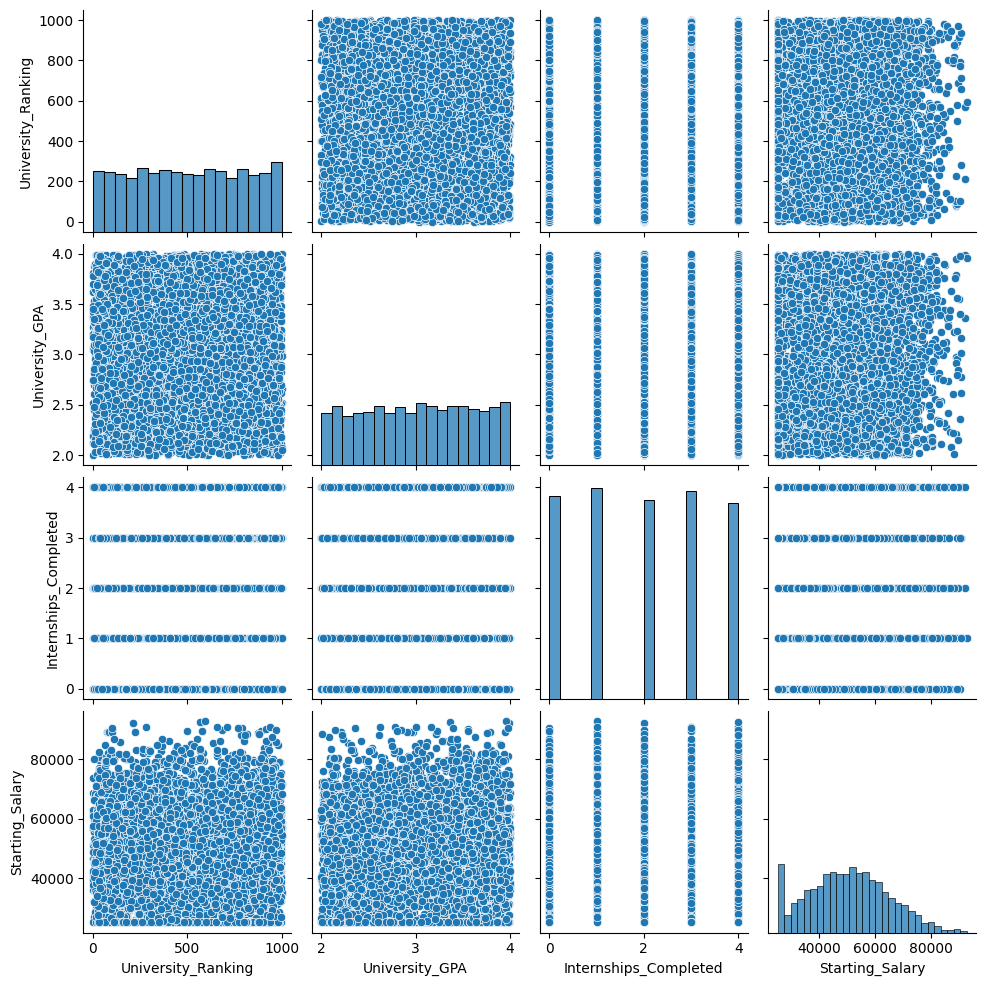

In [ ]:
# все графики вместе для удобства

sns.pairplot(df[['University_Ranking', 'University_GPA', 'Internships_Completed', 'Starting_Salary']])
plt.show()

<ipython-input-9-6561f6eb5f27>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Field_of_Study'], palette='Set1')


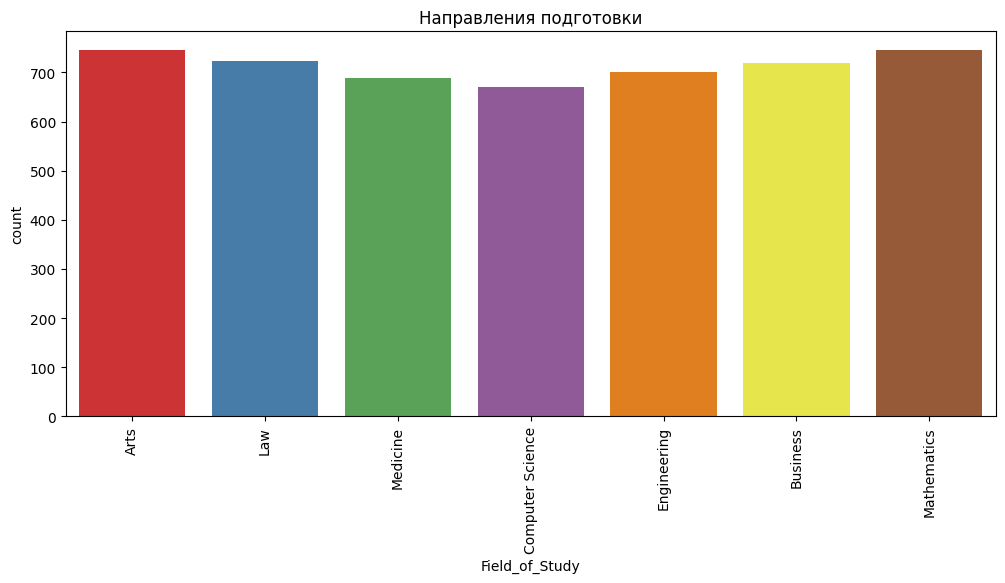

In [ ]:
# направления
plt.figure(figsize=(12,5))
sns.countplot(x=df['Field_of_Study'], palette='Set1')
plt.xticks(rotation=90)
plt.title("Направления подготовки")
plt.show()

# 4. Гипотезы

In [ ]:
#191 "иных", забудем о них
df['Gender'].value_counts()
df = df[df['Gender'].isin(['Male', 'Female'])]

In [ ]:
Male_salary = df[df['Gender'] == 'Male']['Starting_Salary']
Female_salary = df[df['Gender'] == 'Female']['Starting_Salary']

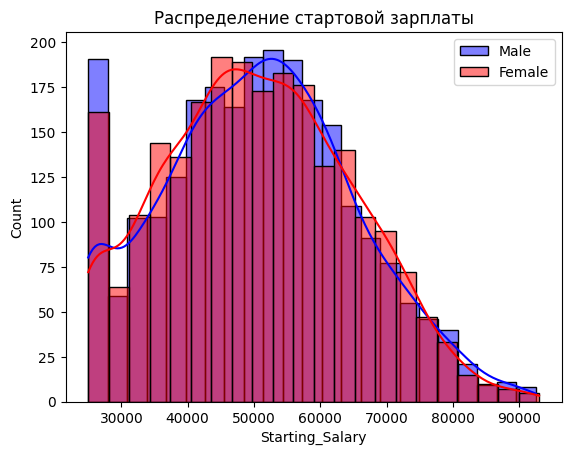

In [ ]:
# Визуализация распределения
sns.histplot(Male_salary, color='blue', label='Male', kde=True)
sns.histplot(Female_salary, color='red', label='Female', kde=True)
plt.legend()
plt.title('Распределение стартовой зарплаты')
plt.show()

In [ ]:
# нормальность
print("Тест Шапиро-Уилка для мужчин:", stats.shapiro(Male_salary))
print("Тест Шапиро-Уилка для женщин:", stats.shapiro(Female_salary))

# однородност дисперсий (тест Левена)
print("Тест Левена:", stats.levene(Male_salary, Female_salary))

#  t-тест
t_stat, p_value = stats.ttest_ind(Male_salary, Female_salary)
print(f"Результат t-теста: t = {t_stat}, p-value = {p_value}")

# U-тест Манна-Уитни (если данные не нормальные) хотя числа +- одинаковые выходят
u_stat, p_value_mannwhitney = stats.mannwhitneyu(Male_salary, Female_salary)
print(f"Результат U-теста: U = {u_stat}, p-value = {p_value_mannwhitney}")

Тест Шапиро-Уилка для мужчин: ShapiroResult(statistic=0.9860374301038467, pvalue=8.654144266116744e-15)
Тест Шапиро-Уилка для женщин: ShapiroResult(statistic=0.9867410364424045, pvalue=5.7996027574578e-14)
Тест Левена: LeveneResult(statistic=0.03656651092997063, pvalue=0.8483584103619164)
Результат t-теста: t = 0.22999033418300532, p-value = 0.8181090828788282
Результат U-теста: U = 2890673.0, p-value = 0.8203215280258793


In [ ]:
# гипотеза 4

technical = df[df['Field_of_Study'].isin(['Computer Science', 'Mathematics', 'Engineering'])]['Starting_Salary']
humanities = df[df['Field_of_Study'].isin(['Arts', 'Law', 'Medicine', 'Business'])]['Starting_Salary']

# нормальность
print("Тест Шапиро-Уилка для техников:", stats.shapiro(technical))
print("Тест Шапиро-Уилка для гуманитариев:", stats.shapiro(humanities))

# однородност дисперсий (тест Левена)
print("Тест Левена:", stats.levene(technical, humanities ))

#  t-тест
t_stat, p_value = stats.ttest_ind(technical, humanities)
print(f"Результат t-теста: t = {t_stat}, p-value = {p_value}")

# U-тест Манна-Уитни (если данные не нормальные)
u_stat, p_value_mannwhitney = stats.mannwhitneyu(technical, humanities)
print(f"Результат U-теста: U = {u_stat}, p-value = {p_value_mannwhitney}")

Тест Шапиро-Уилка для техников: ShapiroResult(statistic=0.9857608827081499, pvalue=2.63126462571187e-13)
Тест Шапиро-Уилка для гуманитариев: ShapiroResult(statistic=0.9869653755412525, pvalue=2.7338444564567143e-15)
Тест Левена: LeveneResult(statistic=0.5328971056778243, pvalue=0.46542702745863807)
Результат t-теста: t = 0.5053966899907362, p-value = 0.6133034531454333
Результат U-теста: U = 2835459.5, p-value = 0.5850575269232392


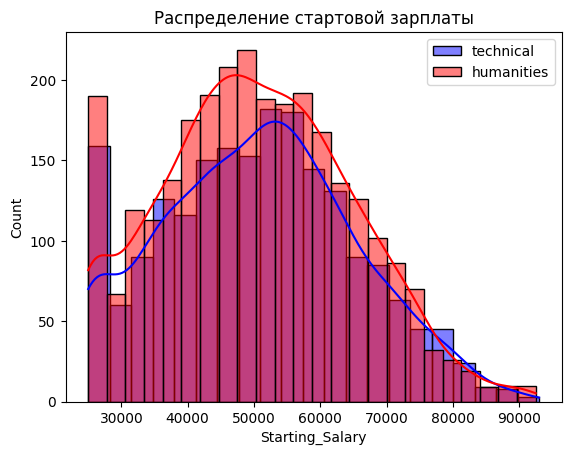

In [ ]:
# Визуализация распределения
sns.histplot(technical, color='blue', label='technical', kde=True)
sns.histplot(humanities, color='red', label='humanities', kde=True)
plt.legend()
plt.title('Распределение стартовой зарплаты')
plt.show()

# 5. линейная регрессия

In [ ]:
# OHE
df = pd.get_dummies(df, columns = df.select_dtypes(include = ['object']).columns, drop_first=True, dtype=int)

# обозначение переменных
X = df.drop('Starting_Salary', axis = 1)
y = df['Starting_Salary']

from sklearn.preprocessing import StandardScaler

column_names = df.columns.tolist()

# нормируем
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=column_names[:-1])

#разделили
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=666)

In [ ]:
#обучаем

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
# проверяяем качество

y_pred = reg.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"R^2 на тестовой выборке: {r2}")
print(f"Интерсепт: {reg.intercept_}")

R^2 на тестовой выборке: -0.011391729728652766
Интерсепт: 50674.75176064227


In [ ]:
for coef, col in sorted(zip((reg.coef_), X.columns), key=lambda x: x[0], reverse=True):
    print(f"Переменная: {col}, Коэффициент: {coef}")

Переменная: Age, Коэффициент: 364.49222029930297
Переменная: Projects_Completed, Коэффициент: 312.0799384895595
Переменная: Career_Satisfaction, Коэффициент: 288.32192451759414
Переменная: Soft_Skills_Score, Коэффициент: 263.2522687909437
Переменная: Starting_Salary, Коэффициент: 217.15682269300189
Переменная: Internships_Completed, Коэффициент: 186.45693701868632
Переменная: Current_Job_Level_Senior, Коэффициент: 161.69611170009472
Переменная: Networking_Score, Коэффициент: 147.20787191085984
Переменная: Field_of_Study_Medicine, Коэффициент: 130.79792207038702
Переменная: Years_to_Promotion, Коэффициент: 89.44761777562971
Переменная: Work_Life_Balance, Коэффициент: 87.94962759454808
Переменная: Current_Job_Level_Mid, Коэффициент: 73.59238028564444
Переменная: University_Ranking, Коэффициент: 71.53415362061929
Переменная: University_GPA, Коэффициент: 60.42608192727087
Переменная: High_School_GPA, Коэффициент: -36.577086974478306
Переменная: Field_of_Study_Business, Коэффициент: -111.73

<BarContainer object of 25 artists>

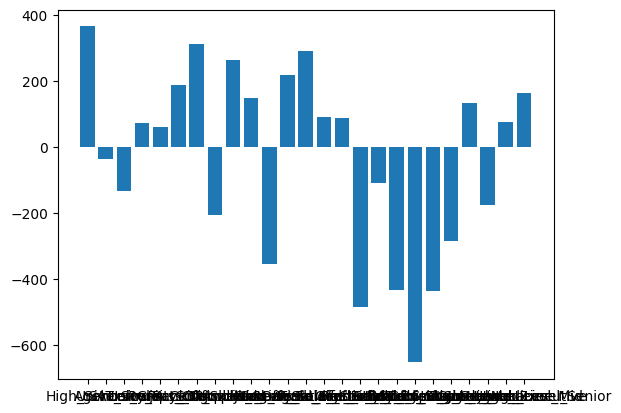

In [ ]:
plt.bar(X.columns, reg.coef_)

LM Statistic: 19.484136737895, p-value: 0.773335105351242


Text(0.5, 1.0, 'Residuals vs Predicted')

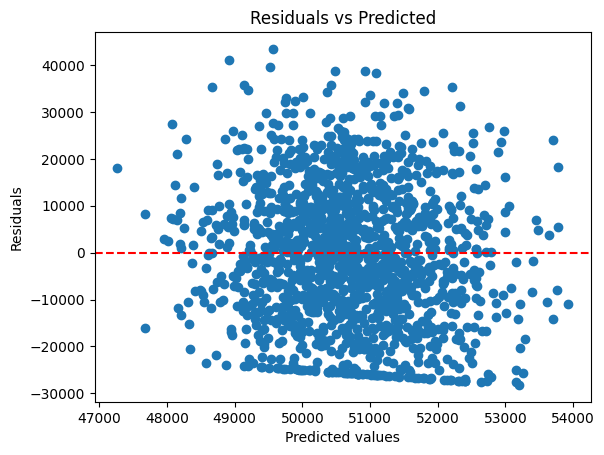

In [ ]:
# гетероскедастичность

residuals = y_test - y_pred
X_with_const = sm.add_constant(X_test)

#print(X_with_const.shape, residuals.shape)

# Тест Бреуша-Пагана
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(residuals, X_with_const)
print(f"LM Statistic: {lm}, p-value: {lm_p_value}")

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")


In [ ]:
# автокорреляция
dw_statistic = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_statistic}")
# близкое к 2, значит ее нет

Durbin-Watson Statistic: 1.9993687338116495


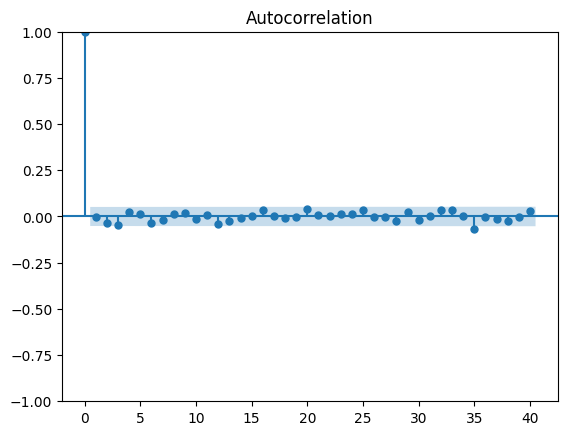

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals, lags=40)
plt.show()